In [1]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from statsmodels.tsa.vector_ar.var_model import VAR

In [2]:
# 2.Load Dataset
data = pd.read_csv("halong_quality.csv")
data

,date,pm25,pm10,o3,no2,so2,co
0,3/1/2019,6,6,45,3,500,NaN
1,3/2/2019,59,55,1,6,500,NaN
2,3/3/2019,43,28,5,9,500,NaN
3,3/4/2019,27,3,4,16,500,NaN
4,3/5/2019,48,17,16,1,500,NaN
...,...,...,...,...,...,...,...
1915,5/28/2024,64,32,48,9,500,NaN
1916,5/29/2024,47,20,23,8,500,NaN
1917,5/30/2024,40,6,49,9,500,NaN
1918,5/31/2024,12,18,14,8,500,NaN


In [3]:
#kích thước dữ liệu
data.shape
data.info()
#Mô tả bộ dữ liệu
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1920 non-null   object 
 1   pm25    1920 non-null   int64  
 2   pm10    1920 non-null   int64  
 3   o3      1920 non-null   int64  
 4   no2     1920 non-null   int64  
 5   so2     1920 non-null   int64  
 6   co      0 non-null      float64
dtypes: float64(1), int64(5), object(1)
memory usage: 105.1+ KB


,pm25,pm10,o3,no2,so2,co
count,1920.000000,1920.000000,1920.000000,1920.000000,1920.0,0.0
mean,40.085938,23.563021,18.845833,9.697396,500.0,NaN
std,22.956887,13.469754,20.556540,7.802379,0.0,NaN
min,5.000000,3.000000,1.000000,1.000000,500.0,NaN
25%,22.000000,13.000000,8.000000,1.000000,500.0,NaN
50%,38.000000,22.000000,13.000000,9.000000,500.0,NaN
75%,54.000000,32.000000,22.000000,15.000000,500.0,NaN
max,163.000000,86.000000,268.000000,36.000000,500.0,NaN


In [4]:
#Chọn thuộc tính
data = data[['pm25','pm10']]
data = data.dropna() 
data = data.reset_index(drop=True) 
data

,pm25,pm10
0,6,6
1,59,55
2,43,28
3,27,3
4,48,17
...,...,...
1915,64,32
1916,47,20
1917,40,6
1918,12,18


In [5]:
def smoothed(data):
    # Apply moving average filter to smooth the forecasted values
    window_size = 5  # You can adjust the window size as needed
    forecast_smoothed = data.rolling(window=window_size).mean()

    # Interpolate NaN values resulting from the moving average
    forecast_smoothed_interpolated = forecast_smoothed.interpolate()

    # Fill remaining NaN values
    forecast_smoothed_filled = forecast_smoothed_interpolated.fillna(method='bfill')  # or 'ffill', or use fillna(value=0)
    
    return forecast_smoothed_filled

# Example usage
data = smoothed(data)

<Axes: >

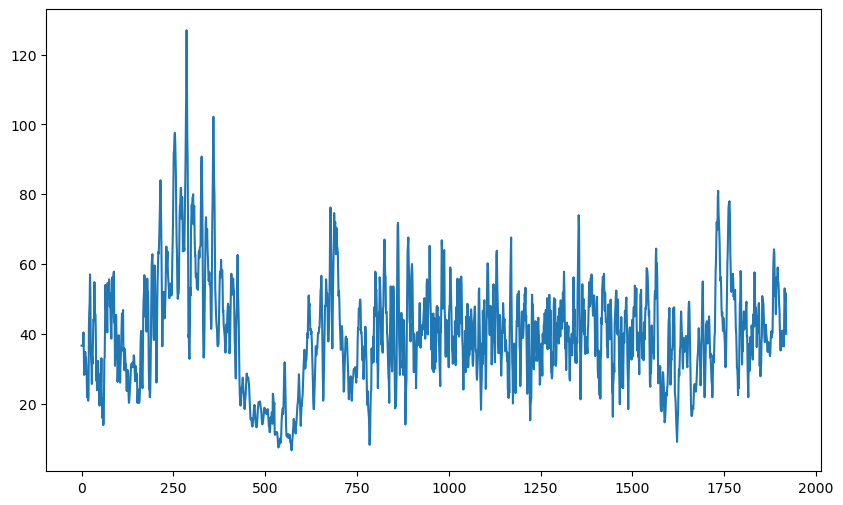

In [6]:
data['pm25'].plot(figsize=(10,6))

In [7]:
# Split the data into training, testing
train_size = int(0.7 * len(data))
test_size = int(0.3 * len(data))

train_data = data[:train_size]
test_data = data[train_size:]

# Kiểm tra kích thước của từng tập
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 1344
Test data size: 576


In [8]:
# 3. Quá trình Training
model = VAR(train_data)
model_fitted = model.fit(maxlags =15 , ic='aic')

In [9]:
# 4. Quá trình testing 
# Dự đoán cho cả 'pm25' và 'pm10'
y_pred = model_fitted.forecast(train_data.values[-model_fitted.k_ar:], steps=len(test_data))


In [10]:
y_pred = pd.DataFrame(y_pred, columns=['pm25', 'pm10'])
y_pred = smoothed(y_pred)
y_pred = y_pred.to_numpy()

In [11]:
y_pred

array([[41.12344012, 30.67537517],
       [41.12344012, 30.67537517],
       [41.12344012, 30.67537517],
       ...,
       [40.57843654, 24.43959928],
       [40.57843559, 24.43959872],
       [40.57843466, 24.43959816]])

In [12]:

# 5. Quá trình tạo index predict 90 ngày tiếp theo
last_index = data.index[-1]

# # Dự đoán cho 90 ngày tiếp theo
y_next_90_days = model_fitted.forecast(data.values[-model_fitted.k_ar:], steps=90)



# Print the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)



Predicted closing prices for the next 90 days:
[[36.67825172 18.78667615]
 [35.56093295 18.91763579]
 [31.60623395 21.48403719]
 [33.74369587 20.8189566 ]
 [36.56981416 22.17890782]
 [36.50842944 23.07153746]
 [38.70622493 23.15315601]
 [41.15598013 23.97826469]
 [39.12290552 23.93590195]
 [41.46597623 24.84195165]
 [42.25464238 24.9298224 ]
 [41.42218699 25.62881492]
 [41.23613531 24.34991021]
 [42.28298216 24.89151237]
 [39.72577413 24.06014348]
 [39.56432572 23.64752673]
 [39.30695344 23.07771529]
 [38.31498331 23.6240049 ]
 [38.32822196 23.17769044]
 [39.0792172  23.40403759]
 [38.81607167 23.74546755]
 [39.18911753 23.78597064]
 [40.08403851 23.90251025]
 [39.57829689 24.06688599]
 [40.10442036 24.18933357]
 [40.33621962 24.08498013]
 [40.29422746 24.37343612]
 [40.06303951 24.13480458]
 [40.54697134 24.20932308]
 [39.95591371 24.12466717]
 [39.97880112 24.09984185]
 [39.91249407 23.89800376]
 [39.75645498 24.027013  ]
 [39.61872606 23.92876084]
 [39.83014184 23.92238838]
 [39.743

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Tính RMSE
rmse = np.sqrt(mean_squared_error(test_data['pm25'], y_pred[:, 0]))
print('Testing RMSE:', rmse)

# Tính MAE
mae = mean_absolute_error(test_data['pm25'], y_pred[:, 0])
print('\nTesting MAE:', mae)

# Tính MAPE
mape = np.mean(np.abs((test_data['pm25'] - y_pred[:, 0]) / test_data['pm25'])) * 100
print('\nTesting MAPE:', mape)


Testing RMSE: 12.068741984378152

Testing MAE: 9.364846858889601

Testing MAPE: 28.234688131831504


In [14]:
test_data.index

RangeIndex(start=1344, stop=1920, step=1)

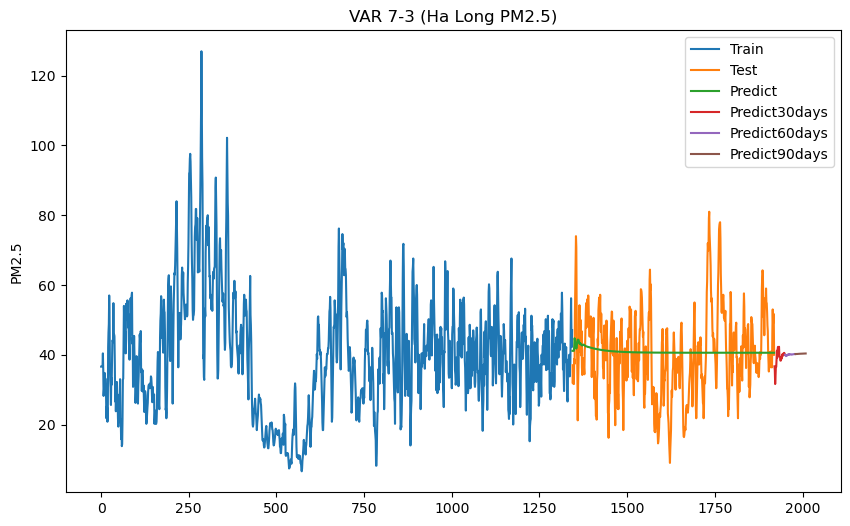

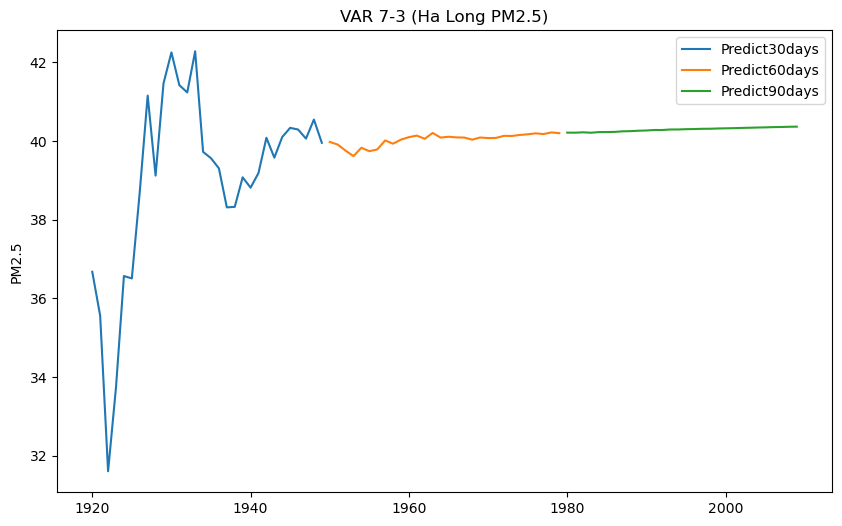

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Giả sử last_index và y_next_90_days đã được định nghĩa trước đó
# Bạn có thể thay thế chúng bằng dữ liệu thực tế của mình

# Vẽ biểu đồ huấn luyện và kiểm tra với dự đoán
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data['pm25'], label='Train')
plt.plot(test_data.index, test_data['pm25'], label='Test')
plt.plot(test_data.index, y_pred[:, 0], label='Predict')

# Vẽ dự đoán 90 ngày
last_index = data.index[-1]  # Giả sử last_index là index cuối cùng của train_data

last_data = pd.RangeIndex(start=last_index + 1, stop=last_index + 31, step=1)
plt.plot(last_data, y_next_90_days[0:30][:, 0], label='Predict30days')

last_data = pd.RangeIndex(start=last_index + 31, stop=last_index + 61, step=1)
plt.plot(last_data, y_next_90_days[30:60][:, 0], label='Predict60days')

last_data = pd.RangeIndex(start=last_index + 61, stop=last_index + 91, step=1)
plt.plot(last_data, y_next_90_days[60:90][:, 0], label='Predict90days')

plt.legend()
plt.title('VAR 7-3 (Ha Long PM2.5)')
plt.ylabel('PM2.5')
plt.show()

# Vẽ dự đoán 90 ngày với kích thước 14x7
plt.figure(figsize=(10, 6))
last_data = pd.RangeIndex(start=last_index + 1, stop=last_index + 31, step=1)
plt.plot(last_data, y_next_90_days[0:30][:, 0], label='Predict30days')

last_data = pd.RangeIndex(start=last_index + 31, stop=last_index + 61, step=1)
plt.plot(last_data, y_next_90_days[30:60][:, 0], label='Predict60days')

last_data = pd.RangeIndex(start=last_index + 61, stop=last_index + 91, step=1)
plt.plot(last_data, y_next_90_days[60:90][:, 0], label='Predict90days')

plt.legend()
plt.title('VAR 7-3 (Ha Long PM2.5)')
plt.ylabel('PM2.5')
plt.show()
